# Part II : The Influence of Kickstarter

This notebook focuses on the influence of Kickstarter in the board game industry. We will compare the launches on Kickstarter with all board game releases, per year and cumulative. Then we can see the ratio of Kickstarter board games per year.

In [1]:
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sqlalchemy import create_engine

engine = create_engine("sqlite:///../data/database/data_2018-05-10.db")

First we need to create the `DataFrame` that contains only board games that have `Crowdfunding: Kickstarter` (bgg_id=8374) as a `family` tag.

In [3]:
join_boardgame_families_with_kickstarter = "SELECT * FROM families_to_boardgames ftb " \
"INNER JOIN families f ON ftb.family_id=f.id WHERE f.bgg_id=8374"
query = "SELECT b.id AS id, b.name AS name, b.num_ratings AS num_ratings, b.avg_rating AS avg_rating, " \
"b.year_published AS year_published FROM (" + join_boardgame_families_with_kickstarter + \
") sub INNER JOIN boardgames b ON sub.boardgame_id=b.id WHERE year_published < 2018 ;"
kickstarter_df = pd.read_sql(query, engine)
kickstarter_df.head()

,id,name,num_ratings,avg_rating,year_published
0,379,Last Frontier: The Vesuvius Incident,179,6.98771,1993
1,385,Bobby Lee,314,6.83937,1993
2,398,Speculation,640,6.73223,1992
3,847,Shadowfist,400,7.10812,1995
4,977,Monster Derby,120,6.11875,1994


Now `kickstarter_df` contains every board game that has the `Crowdfunding: Kickstarter`-Tag on BGG. It is worth to note the data does include many old games that received reprints, anniversary editions and so on.

Next we will count the releases per year. The `year_published` column does not necessarily indicate the year of the kickstarter campaign, only the original release date of the game. Therefore reprints etc. will not be included in this per-year-list, because we will later on only look at the numbers since Kickstarter launched, which is 2009.

In [4]:
kickstarter_by_year_df = pd.DataFrame(kickstarter_df.groupby("year_published")["id"].count())
kickstarter_by_year_df.columns = ["count"]
kickstarter_by_year_df = kickstarter_by_year_df.reset_index()
kickstarter_by_year_df["year"] = kickstarter_by_year_df["year_published"]
kickstarter_by_year_df = kickstarter_by_year_df.drop("year_published", axis=1)
kickstarter_by_year_df.tail(10)

,count,year
14,5,2008
15,11,2009
16,20,2010
17,42,2011
18,115,2012
19,206,2013
20,313,2014
21,371,2015
22,347,2016
23,274,2017


Now that we have all Kickstarter board games, we need to load a `DataFrame` containing every board game and we also count the number of games per year.

In [5]:
published_df = pd.read_sql("select count(id) as count, year_published from boardgames where year_published < 2018 group by year_published;", engine)
published_df["year_published"] = pd.to_datetime(published_df["year_published"], format="%Y")
published_df['year'] = pd.DatetimeIndex(published_df['year_published']).year
published_df = published_df.drop("year_published", axis=1)
published_df.tail(10)

,count,year
18,650,2008
19,707,2009
20,773,2010
21,795,2011
22,886,2012
23,908,2013
24,1045,2014
25,1160,2015
26,1225,2016
27,1045,2017


Now we combine both `DataFrame`s and only look at games published in 2009 (Kickstarter launch) or later.

In [7]:
kickstarter_by_year_df.columns = ["count_ks", "year"]
combined_df = kickstarter_by_year_df.join(published_df.set_index("year"), on="year")
combined_df["ks_ratio"] = combined_df["count_ks"].div(combined_df["count"]).mul(100)
combined_df = combined_df[combined_df["year"] >= 2009]
combined_df.tail()

,count_ks,year,count,ks_ratio
19,206,2013,908,22.687225
20,313,2014,1045,29.952153
21,371,2015,1160,31.982759
22,347,2016,1225,28.326531
23,274,2017,1045,26.220096


## Total Releases And Launches On Kickstarter Per Year And Their Ratio

The crowdfunding platform *Kickstarter* was launched in 2009. The following plot shows the board game publications per year and the cumulative publications over the years. Note that the publications per year do not include games that been originally created before 2009 and received a reprint in or after 2009, so the numbers should be slightly higher.

Board games are no joke on Kickstarter. The most successfull board game on Kickstarter, *Kingdom Death: Monster* raised over 12 *million* dollars. It is the *fourth* most funded project on Kickstarter. There are *dozens* of board games that raised over a million.

The following plot showcases the ratio of kickstarter games per year with respect to all board game publications per year. We can clearly see that Kickstarter plays a significant role in the publishing process of board games. In 2015 almost *one-third* of all board game releases have used Kickstarter.

c:\program files\python363\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


Text(2008.1,-14,'  ©Jan Barrera                                                                                                   Source: www.boardgamegeek.com  ')

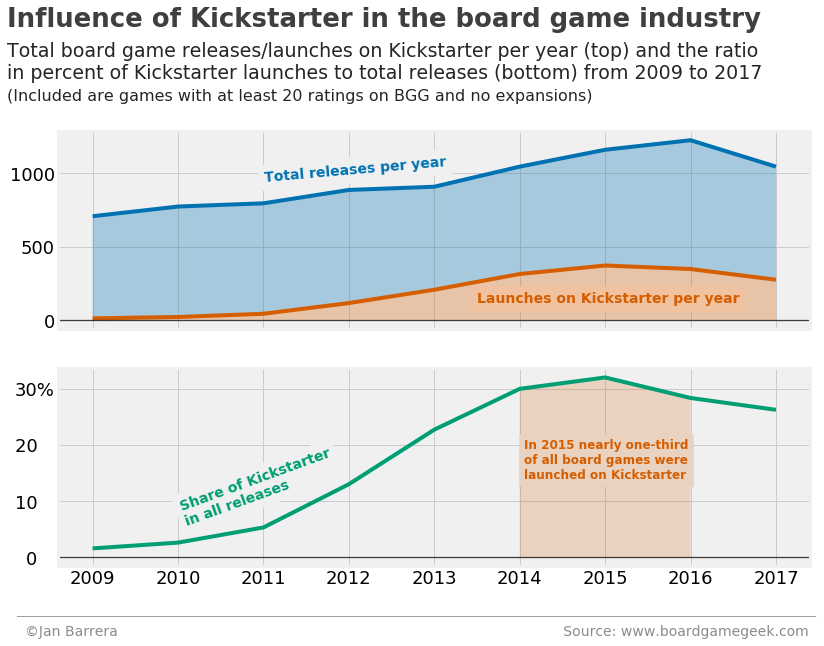

In [8]:
blue = [0, 114/255, 178/255]
bluegreen = [0, 158/255, 115/255]
orange = [213/255, 94/255, 0]

### Top Plot ###

# Plot total count and Kickstarter count
ax = plt.subplot(2, 1, 1)
combined_df.plot("year", ["count", "count_ks"], color=[blue, orange], figsize=(12, 8), fontsize=16, legend=False, ax=ax)

# Fill the areas below the plots
ax.fill_between(combined_df["year"], 0, combined_df["count_ks"], facecolor=orange, alpha=0.3)
ax.fill_between(combined_df["year"], combined_df["count_ks"], combined_df["count"], facecolor=blue, alpha=0.3)

# Axis Settings
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.tick_params(axis="both", which="major", labelsize=18)
ax.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)

# Labels
ax.text(x=2011, y=1050, s="Total releases per year", color=blue, weight="bold", rotation=5,
       backgroundcolor="#f0f0f0", fontsize=14, zorder=3)
ax.text(x=2013.5, y=120, s="Launches on Kickstarter per year", color=orange, weight="bold", rotation=0,
       backgroundcolor="#F1C29F", fontsize=14, zorder=3)

# Title and subtitle
ax.text(x=2008, y=2000, s="Influence of Kickstarter in the board game industry", fontsize=26, weight="bold",
       alpha=0.75)
ax.text(x=2008, y=1500, s="Total board game releases/launches on Kickstarter per year (top) and the ratio\nin percent of Kickstarter launches to total releases (bottom) from 2009 to 2017\n",
       fontsize=19, alpha=0.85)
ax.text(x=2008, y=1500, s="(Included are games with at least 20 ratings on BGG and no expansions)",
        fontsize=16, alpha=0.85)

### Bottom Plot ###

# Plot the ratio of Kickstarter board games
ax2 = plt.subplot(2, 1, 2, sharex=ax)
combined_df.plot("year", "ks_ratio", color=[bluegreen], figsize=(12, 8), fontsize=16, legend=False, ax=ax2)

# Axis Settings
ax2.xaxis.label.set_visible(False)
ax2.yaxis.label.set_visible(False)
ax2.tick_params(axis="both", which="major", labelsize=18)
ax2.axhline(y=0, color="black", linewidth=1.3, alpha=0.7)
ax2.set_yticklabels(labels = [-10, '0   ', '10   ', '20   ', '30%'])

# Labels
ax2.text(x=2010, y=15, s="Share of Kickstarter\nin all releases", color=bluegreen, weight="bold", rotation=20,
       backgroundcolor="#f0f0f0", fontsize=14, zorder=3)

# Specials
orange = [213/255, 94/255, 0]
small_df = combined_df[(combined_df["year"] >= 2014) & (combined_df["year"] <= 2016)]
ax2.fill_between(small_df["year"], 0, small_df["ks_ratio"], facecolor=orange, alpha=0.2)
ax2.text(x=2014.05, y=14, s="In 2015 nearly one-third\nof all board games were\nlaunched on Kickstarter", weight="bold", color=orange, rotation=0,
       backgroundcolor="#ead2c0", fontsize=12, zorder=3)

# Signature bar
ax2.text(x=2008.1, y=-10, s="________________________________________________________________________________________________________________________________________________________________",
       color="grey", alpha=0.9)
ax2.text(x=2008.1, y=-14, s="  ©Jan Barrera                                                                                                   Source: www.boardgamegeek.com  ",
       fontsize=14, color="grey", alpha=0.9)